In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from typing import Dict, List, Tuple

from jupyter_lsp.specs import ts_old
from tqdm import tqdm

# Statistical analysis
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

# Machine learning
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier

# Custom modules
from src.data.dataLoader import StructuralBreakDataLoader, TimeSeriesData
from src.utils.training_class import TimeSeriesModelTrainer

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("📦 All packages imported successfully!")

📦 All packages imported successfully!


In [64]:
# Load the data
print("📊 Loading structural break data...")
data_loader = StructuralBreakDataLoader()
X_train, y_train, X_test = data_loader.load_data(use_crunch=False)

# Get all time series
train_series = data_loader.get_all_train_series()
test_series = data_loader.get_all_test_series()

# Display basic statistics
stats = data_loader.get_statistics()
print(f"\n✅ Data loaded successfully!")
print(f"📈 Training series: {len(train_series):,}")
print(f"🧪 Test series: {len(test_series):,}")
print(f"✅ Positive examples (breaks): {stats['n_positive']:,} ({stats['positive_ratio']:.1%})")
print(f"❌ Negative examples (no breaks): {stats['n_negative']:,}")
print(f"📏 Series length range: {stats['min_length']} - {stats['max_length']} (mean: {stats['mean_length']:.1f})")

📊 Loading structural break data...


INFO:src.data.dataLoader:Data loaded successfully from local files



✅ Data loaded successfully!
📈 Training series: 10,001
🧪 Test series: 101
✅ Positive examples (breaks): 2,909 (29.1%)
❌ Negative examples (no breaks): 7,092
📏 Series length range: 1258 - 3478 (mean: 2371.3)


In [3]:
def _build_lagged_matrix(series: np.ndarray, lags: int) -> Tuple[np.ndarray, np.ndarray]:
    """Build lagged design matrix X and vector y."""
    N = len(series)
    if N <= lags:
        return None, None

    y = series[lags:]
    X = np.ones((N - lags, lags + 1), dtype=float)

    for j in range(1, lags + 1):
        X[:, j] = series[lags - j: N - j]

    return X, y

In [4]:
def _ols_fit(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray, float]:
    """Fit OLS: returns beta, residuals, rss."""
    XT_X = X.T.dot(X)
    try:
        beta = np.linalg.solve(XT_X, X.T.dot(y))
    except np.linalg.LinAlgError:
        beta = np.linalg.pinv(XT_X).dot(X.T.dot(y))

    resid = y - X.dot(beta)
    rss = float(resid.dot(resid))

    return beta, resid, rss

In [5]:
def get_sig_pacf_lags(series: np.ndarray, max_lag: int = 15, alpha: float = 0.05) -> List[int]:
    """Get list of lags with significant PACF values."""
    try:
        vals, conf = pacf(series, nlags=max_lag, alpha=alpha)
        sig_lags = [
            lag for lag in range(1, len(vals))
            if (conf[lag][1] < 0) or (conf[lag][0] > 0)
        ]
        return sig_lags
    except:
        return []

In [6]:
def count_sig_pacf_lags(series: np.ndarray, max_lag: int = 15, alpha: float = 0.05) -> int:
    """Count number of significant PACF lags."""
    sig_lags = get_sig_pacf_lags(series, max_lag, alpha)
    return len(sig_lags) if sig_lags else 1  # Return at least 1

100%|██████████| 10001/10001 [00:16<00:00, 609.26it/s]


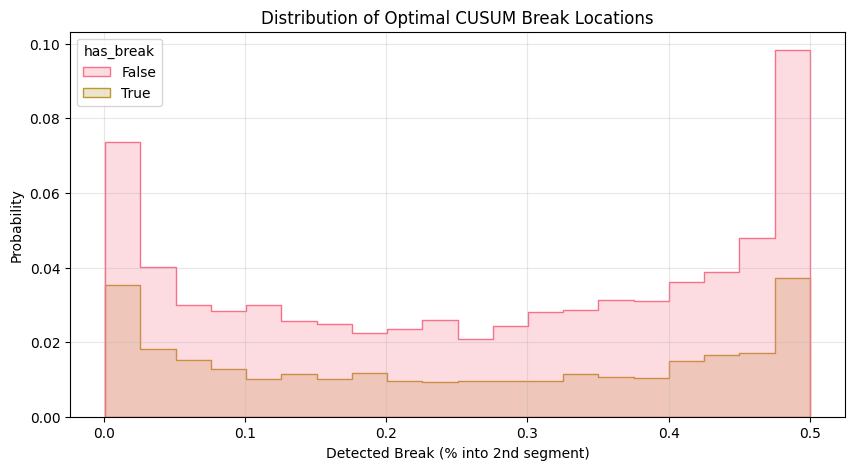

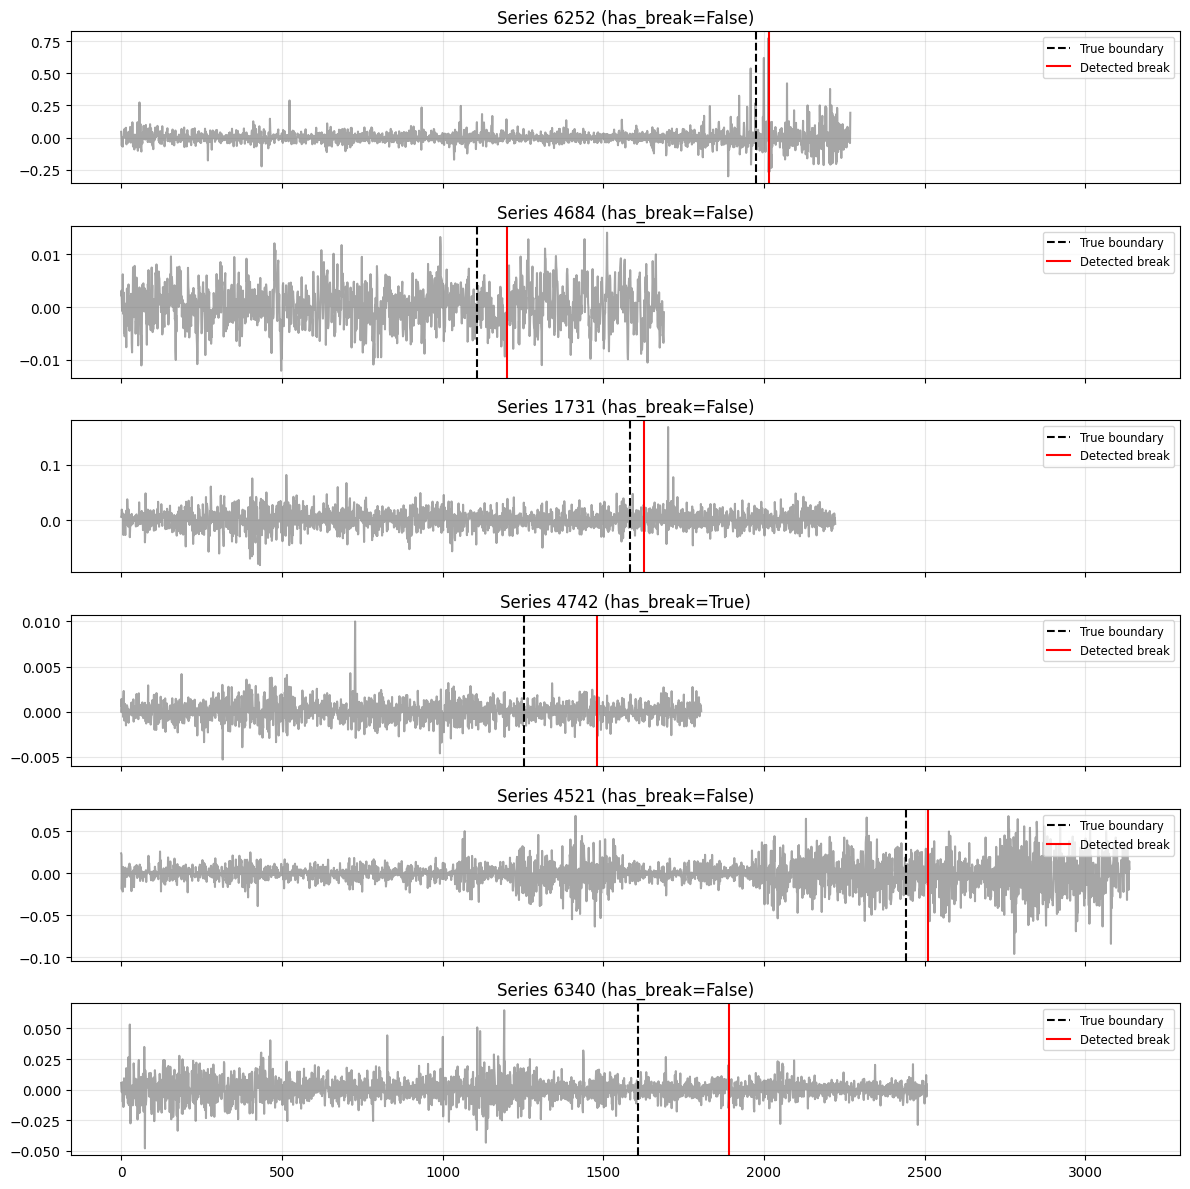

In [10]:
# %% 
# ---  Add this cell after compute_cusum_statistics  ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def find_optimal_cusum_break(ts_obj, lags: int):
    """
    Scan over all candidate k in the *second* segment of ts_obj,
    compute the CUSUM T-stat at each, and return:
      - best_k: absolute index in the full series 
      - T_values: array of T_cusum for each candidate
    """
    series = ts_obj.values
    K0     = len(ts_obj.period_0_values)
    N      = len(series)
    sec_len = len(ts_obj.period_1_values)

    # build full lagged matrix once
    X_full, y_full = _build_lagged_matrix(series, lags)
    if X_full is None:
        return np.nan, np.array([])

    # these residuals and rss are for the "pooled" regression
    beta_full, resid_full, rss_full = _ols_fit(X_full, y_full)
    n_full = len(y_full)
    sigma_hat = np.sqrt(rss_full / (n_full - (lags+1)))

    # candidate ks: from boundary+lags up to N-lags (so both sides have at least one obs)
    
    # ks = np.arange(K0 + lags, N - lags + 1)
    start_k = K0 + lags
    end_k   = K0 + int(sec_len / 2)
    ks = np.arange(start_k, min(end_k + 1, N - lags + 1))
    
    T_vals = []
    for k in ks:
        # effective split in residuals: k_eff = k - lags
        k_eff = k - lags
        u     = k_eff / n_full
        S     = resid_full[:k_eff].sum()
        denom = sigma_hat * np.sqrt(n_full * u * (1 - u))
        T_vals.append(S / denom)
    T_vals = np.array(T_vals)
    # pick the k with max |T|
    idx = np.argmax(np.abs(T_vals))
    best_k = ks[idx]
    return best_k, T_vals

# Apply to *all* series
break_info = []
for sid, ts in tqdm(train_series.items()):
    # pick lag via your preferred strategy, e.g. PACF-count:
    full = ts.values
    lag = count_sig_pacf_lags(full, max_lag=15, alpha=0.05)
    k_star, T_vals = find_optimal_cusum_break(ts, lag)
    # express position within second segment:
    pct = (k_star - len(ts.period_0_values)) / len(ts.period_1_values) if not np.isnan(k_star) else np.nan
    break_info.append({
        'series_id': sid,
        'has_break': ts.has_break,
        'best_k': k_star,
        'pct_into_second': pct
    })

break_df = pd.DataFrame(break_info).set_index('series_id')

# ## Plot distribution of detected break location ##
plt.figure(figsize=(10,5))
sns.histplot(data=break_df.dropna(), x='pct_into_second',
             hue='has_break', bins=20, element='step', stat='probability')
plt.xlabel('Detected Break (% into 2nd segment)')
plt.title('Distribution of Optimal CUSUM Break Locations')
plt.grid(alpha=0.3)
plt.show()

# ## Show some series with their detected break ##
n_examples = 6
fig, axes = plt.subplots(n_examples, 1, figsize=(12, 2*n_examples), sharex=True)

sample = break_df.dropna().sample(n_examples, random_state=42)
for ax, (sid, row) in zip(axes, sample.iterrows()):
    ts = train_series[sid]
    ax.plot(ts.values, color='grey', alpha=0.7)
    ax.axvline(len(ts.period_0_values), color='black', linestyle='--', label='True boundary')
    ax.axvline(row['best_k'], color='red', linestyle='-', label='Detected break')
    ax.set_title(f"Series {sid} (has_break={row['has_break']})")
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


<Axes: >

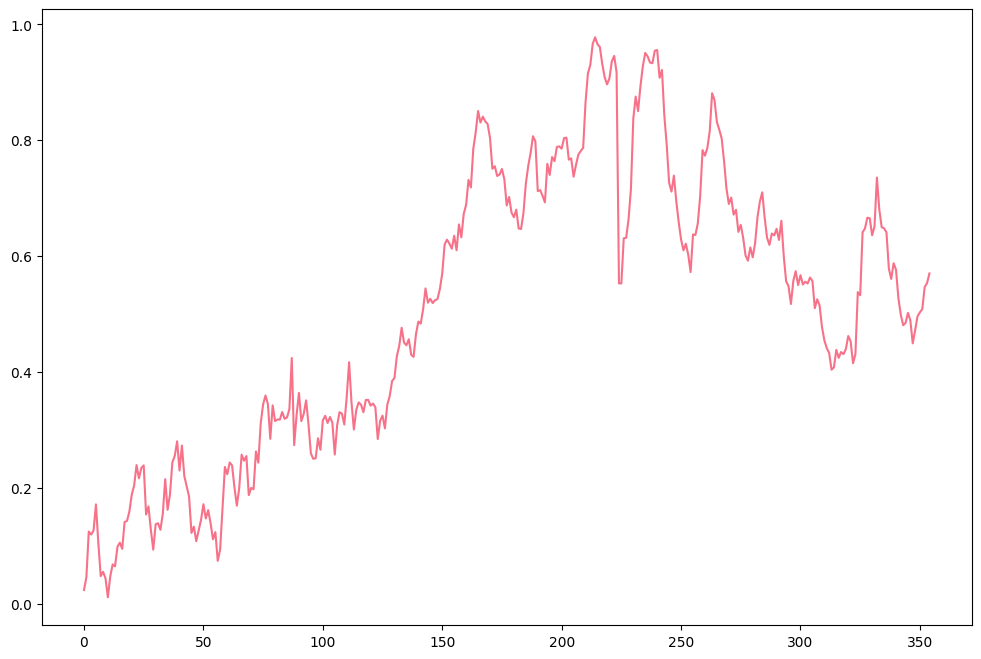

In [159]:
ts_obj = train_series[i]
i+= 1
lags = count_sig_pacf_lags(ts_obj, max_lag=20, alpha=0.05)
series = ts_obj.values
K0     = len(ts_obj.period_0_values)
N      = len(series)
sec_len = len(ts_obj.period_1_values)

# build full lagged matrix once
X_full, y_full = _build_lagged_matrix(series, lags)

# these residuals and rss are for the "pooled" regression
beta_full, resid_full, rss_full = _ols_fit(X_full, y_full)
n_full = len(y_full)
sigma_hat = np.sqrt(rss_full / (n_full - (lags+1)))

# candidate ks: from boundary+lags up to N-lags (so both sides have at least one obs)

# ks = np.arange(K0 + lags, N - lags + 1)
start_k = K0 + lags
end_k   = K0 + int(sec_len / 2)
ks = np.arange(start_k, min(end_k + 1, N - lags + 1))

T_vals = []
for k in ks:
    # effective split in residuals: k_eff = k - lags
    k_eff = k - lags
    u     = k_eff / n_full
    S     = resid_full[:k_eff].sum()
    denom = sigma_hat * np.sqrt(n_full * u * (1 - u))
    T_vals.append(S / denom)
T_vals = np.array(T_vals)
sns.lineplot(np.abs(T_vals))

In [78]:
i=0

100%|██████████| 10001/10001 [00:28<00:00, 355.77it/s]


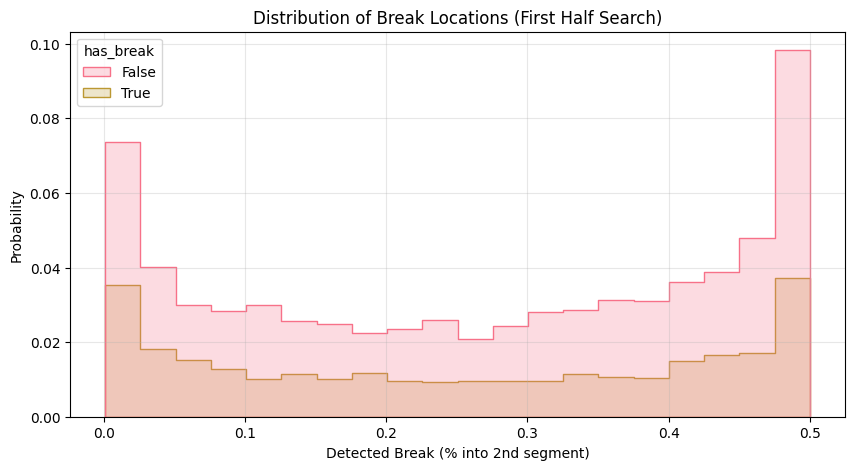

5-fold CV AUC on pct feature:  0.508


In [8]:
# Updated break detection and XGBoost evaluation cell

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

# --- Updated find_optimal_cusum_break restricting search to first half of second segment ---
def find_optimal_cusum_break_first_half(ts_obj, lags: int):
    series = ts_obj.values
    K0     = len(ts_obj.period_0_values)
    N      = len(series)
    sec_len = len(ts_obj.period_1_values)
    
    # build full lagged matrix once
    X_full, y_full = _build_lagged_matrix(series, lags)
    if X_full is None:
        return np.nan, np.array([])
    beta_full, resid_full, rss_full = _ols_fit(X_full, y_full)
    n_full = len(y_full)
    sigma_hat = np.sqrt(rss_full / (n_full - (lags+1)))
    
    # restrict candidate ks to first half of second segment
    # first half end index = K0 + int(sec_len/2)
    start_k = K0 + lags
    end_k   = K0 + int(sec_len / 2)
    ks = np.arange(start_k, min(end_k + 1, N - lags + 1))
    
    T_vals = []
    for k in ks:
        k_eff = k - lags
        u     = k_eff / n_full
        S     = resid_full[:k_eff].sum()
        denom = sigma_hat * np.sqrt(n_full * u * (1 - u))
        T_vals.append(S / denom)
    T_vals = np.array(T_vals)
    
    if T_vals.size == 0:
        return np.nan, T_vals
    idx = np.argmax(np.abs(T_vals))
    best_k = ks[idx]
    return best_k, T_vals

# Apply to all series
break_info = []
for sid, ts in tqdm(train_series.items()):
    full = ts.values
    lag  = count_sig_pacf_lags(full, max_lag=15, alpha=0.05)
    k_star, _ = find_optimal_cusum_break_first_half(ts, lag)
    # pct into second segment
    if np.isnan(k_star):
        pct = np.nan
    else:
        pct = (k_star - len(ts.period_0_values)) / len(ts.period_1_values)
    break_info.append({
        'series_id': sid,
        'has_break': ts.has_break,
        'pct_into_second': pct
    })

break_df = pd.DataFrame(break_info).set_index('series_id')

# Plot distribution
plt.figure(figsize=(10,5))
sns.histplot(data=break_df.dropna(), x='pct_into_second',
             hue='has_break', bins=20, element='step', stat='probability')
plt.xlabel('Detected Break (% into 2nd segment)')
plt.title('Distribution of Break Locations (First Half Search)')
plt.grid(alpha=0.3)
plt.show()

# Train XGBoost on the pct feature
feature_df = break_df[['pct_into_second']].dropna()
label_s    = break_df['has_break'].loc[feature_df.index]

xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.03,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

cv_res = cross_validate(xgb, feature_df, label_s,
                        cv=5, scoring='roc_auc', n_jobs=-1)
print("5-fold CV AUC on pct feature: ", cv_res['test_score'].mean().round(4))


100%|██████████| 10001/10001 [00:17<00:00, 580.77it/s]


5-fold CV AUC using CUSUM features at detected break: 0.5991


C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:34:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


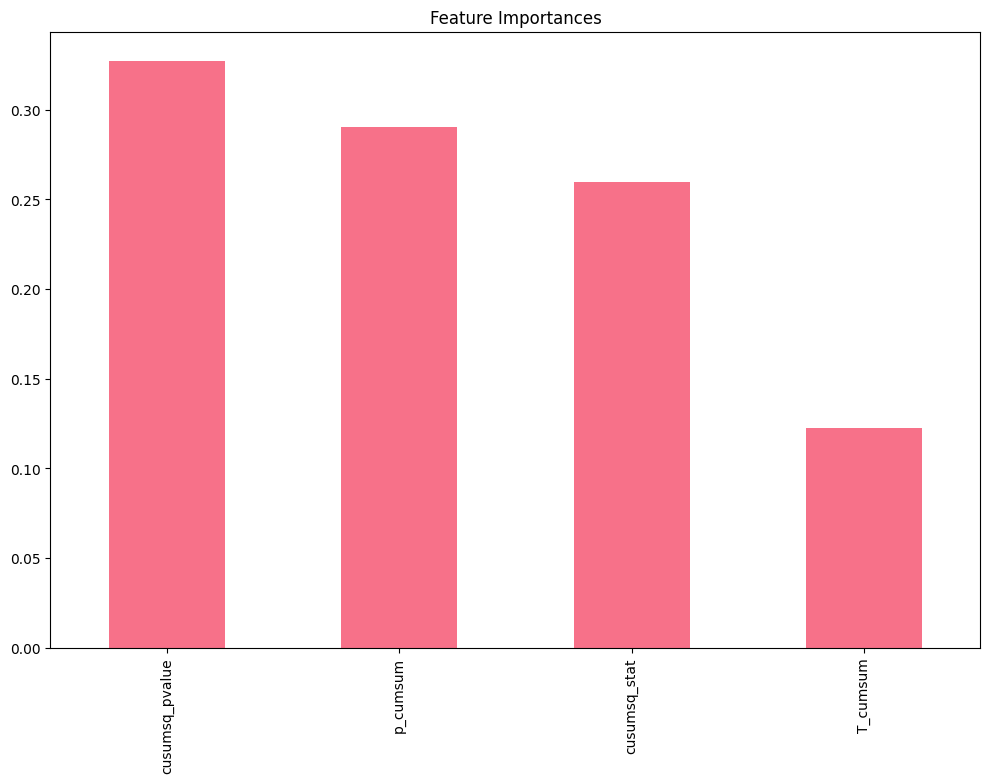

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

# Helper to compute CUSUM/CUSUMSQ at a given break index
def compute_cusum_at_k(series: np.ndarray, lags: int, k: int):
    """
    Compute CUSUM and CUSUMSQ at a fixed break index k.
    series: full numpy array
    lags: number of lags for AR model
    k: absolute break index in series
    """
    from scipy import stats
    
    # build lagged matrix
    N = len(series)
    if N <= lags or not (lags <= k <= N):
        return np.nan, np.nan, np.nan, np.nan
    
    y = series[lags:]
    X = np.ones((N - lags, lags + 1))
    for j in range(1, lags+1):
        X[:, j] = series[lags - j : N - j]
    
    # OLS
    XT_X = X.T @ X
    beta = np.linalg.solve(XT_X, X.T @ y)
    resid = y - X @ beta
    rss = float(resid @ resid)
    
    # CUSUM
    n = len(resid)
    sigma_hat = np.sqrt(rss / (n - (lags+1)))
    k_eff = k - lags
    u = k_eff / n
    S = resid[:k_eff].sum()
    T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
    p_T = 2 * (1 - stats.norm.cdf(abs(T)))
    
    # CUSUMSQ
    sumsq_pre = (resid[:k_eff]**2).sum()
    C = sumsq_pre / rss
    var_C = 2 * u * (1 - u) / (n + 2)
    Z = (C - u) / np.sqrt(var_C)
    p_Z = 2 * (1 - stats.norm.cdf(abs(Z)))
    
    return T, p_T, Z, p_Z

# Assemble features evaluated at the detected break
feature_rows = []
labels = []

for sid, ts in tqdm(train_series.items()):
    full = ts.values
    lag = count_sig_pacf_lags(full, max_lag=15, alpha=0.05)
    k_star, _ = find_optimal_cusum_break_first_half(ts, lag)
    if np.isnan(k_star):
        continue
    T, p_T, Z, p_Z = compute_cusum_at_k(full, lag, int(k_star))
    feature_rows.append({
        'T_cumsum': T,
        'p_cumsum': p_T,
        'cusumsq_stat': Z,
        'cusumsq_pvalue': p_Z
    })
    labels.append(ts.has_break)

feature_df = pd.DataFrame(feature_rows)
label_s = pd.Series(labels, name='has_break')

# Cross-validate XGBoost on these features
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.03,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
cv_res = cross_validate(model, feature_df, label_s, cv=5, scoring='roc_auc', n_jobs=-1)
mean_auc = cv_res['test_score'].mean()

print(f"5-fold CV AUC using CUSUM features at detected break: {mean_auc:.4f}")

# Optional: display feature importances
model.fit(feature_df, label_s)
importances = pd.Series(model.feature_importances_, index=feature_df.columns)
importances.sort_values(ascending=False, inplace=True)
plt.figure()
importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()


100%|██████████| 10001/10001 [03:03<00:00, 54.48it/s]


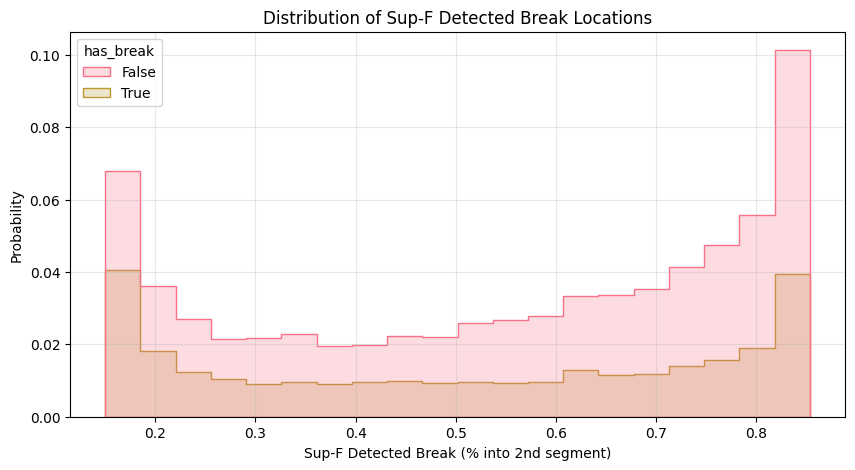

In [12]:
# %% 
# --- Sup-F Scan to Find Break Point ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

def rss_for_span(y: np.ndarray, X: np.ndarray) -> float:
    """Return residual sum of squares for OLS y ~ X."""
    beta, _, _ = _ols_fit(X, y)
    resid      = y - X.dot(beta)
    return float(resid.dot(resid))

def build_Xy(series: np.ndarray, lags: int) -> Tuple[np.ndarray,np.ndarray]:
    """Build common lagged X, y for a series with `lags`."""
    return _build_lagged_matrix(series, lags)

def find_supF_break(ts_obj, lags: int, trim: float = 0.15):
    """
    Scan k over the second segment [K0+lags+trim*n, n-lags-trim*n],
    compute Chow F(k), and return (k*, F_vals, ks).
    """
    series = ts_obj.values
    n      = len(series)
    K0     = len(ts_obj.period_0_values)
    
    # full regression
    X_full, y_full = build_Xy(series, lags)
    if X_full is None: 
        return np.nan, np.array([]), np.array([])
    rss_full = rss_for_span(y_full, X_full)
    df_full  = len(y_full) - X_full.shape[1]
    
    # candidate range: start a bit into the second segment, end a bit before end
    sec_len     = len(ts_obj.period_1_values)
    k_start     = K0 + lags + int(trim*sec_len)
    k_end       = K0 + sec_len - int(trim*sec_len)
    ks          = np.arange(k_start, k_end + 1)
    F_vals      = []
    
    for k in ks:
        # map k→ index in residuals: eff_k = k − lags
        eff_k      = k - lags
        # split X_full, y_full accordingly
        X_pre      = X_full[:eff_k, :]
        y_pre      = y_full[:eff_k]
        X_post     = X_full[eff_k:, :]
        y_post     = y_full[eff_k:]
        
        rss_pre    = rss_for_span(y_pre, X_pre)
        rss_post   = rss_for_span(y_post, X_post)
        rss_split  = rss_pre + rss_post
        
        # degrees of freedom
        df1        = X_full.shape[1]  # number of parameters dropped in split
        df2        = y_full.size - 2*X_full.shape[1]
        
        # Chow F-stat
        num = (rss_full - rss_split) / df1
        den = rss_split / df2
        Fk  = num / den
        F_vals.append(Fk)
    
    F_vals   = np.array(F_vals)
    idx      = np.argmax(F_vals)
    best_k   = ks[idx]
    return best_k, F_vals, ks

# Apply to all series
break_info = []
for sid, ts in tqdm(train_series.items()):
    full = ts.values
    lag  = count_sig_pacf_lags(full, max_lag=15, alpha=0.05)
    k_star, F_vals, ks = find_supF_break(ts, lag, trim=0.15)
    # express as percentage into second segment
    pct = (k_star - len(ts.period_0_values)) / len(ts.period_1_values)
    break_info.append({
        'series_id': sid,
        'has_break': ts.has_break,
        'best_k_supF': k_star,
        'pct_supF': pct
    })

break_df = pd.DataFrame(break_info).set_index('series_id')

# Plot the sup-F distribution
plt.figure(figsize=(10,5))
sns.histplot(data=break_df.dropna(), x='pct_supF',
             hue='has_break', bins=20, element='step', stat='probability')
plt.xlabel('Sup-F Detected Break (% into 2nd segment)')
plt.title('Distribution of Sup-F Detected Break Locations')
plt.grid(alpha=0.3)
plt.show()


In [13]:
# Compute CUSUM‐at‐supF‐break features
feature_rows, labels = [], []
for sid, ts in train_series.items():
    full = ts.values
    lag  = count_sig_pacf_lags(full, max_lag=15, alpha=0.05)
    k_star, _, _ = find_supF_break(ts, lag, trim=0.15)
    if np.isnan(k_star):
        continue
    T, p_T, Z, p_Z = compute_cusum_at_k(full, lag, int(k_star))
    feature_rows.append({'T_cusum': T, 'p_cusum': p_T,
                         'Z_cusum_sq': Z, 'p_cusum_sq': p_Z})
    labels.append(ts.has_break)

feature_df = pd.DataFrame(feature_rows)
label_s    = pd.Series(labels, name='has_break')

# 5-fold CV with XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

model  = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.03,
                       use_label_encoder=False, eval_metric='logloss',
                       random_state=42, n_jobs=-1)
cv_res = cross_validate(model, feature_df, label_s, cv=5, scoring='roc_auc')
print("Sup-F–based CUSUM features AUC:", cv_res['test_score'].mean())


C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\StefanConstantin\Documents\G

Sup-F–based CUSUM features AUC: 0.5644037744224557


C:\Users\StefanConstantin\Documents\Git\Python\ADIA Lab Structural Break Challenge\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:51:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [48]:
# %% [markdown]
# ### 1. Install & import ruptures
# ```bash
# pip install ruptures
# ```

# %%
import ruptures as rpt
import numpy as np
import pandas as pd
from tqdm import tqdm

# 1) Function to detect a single change‐point in the second-half via PELT
def detect_pelt_break(ts_obj, penalty=3):
    """
    Run PELT on just the second segment of ts_obj.values.
    Returns best_k absolute to the full series.
    """
    series = ts_obj.values
    K0 = len(ts_obj.period_0_values)
    sec = series[K0:]                  # second segment
    algo = rpt.Pelt(model="l2").fit(sec)
    # `penalty` controls sensitivity; tune as needed
    bkps = algo.predict(pen=penalty)
    # `bkps` is a list of end‐indices in `sec`; the last one is len(sec)
    # For a single break, bkps[0] is the breakpoint (in second segment coords)

    k_sec = bkps[0]
    return K0 + k_sec  # shift back to full‐series index

# 2) Scan all series, detect via PELT, compute CUSUM at that point
feature_rows = []
labels       = []

for sid, ts in tqdm(train_series.items()):
    full = ts.values
    # pick your lag strategy (e.g. PACF‐count)
    lag = count_sig_pacf_lags(full, max_lag=15, alpha=0.05)
    k_star = detect_pelt_break(ts, penalty=3)
    if np.isnan(k_star) or full.size <= lag:
        continue
    # compute CUSUM features at that break
    T, pT, Z, pZ = compute_cusum_at_k(full, lag, int(k_star))
    feature_rows.append({
        'T_cumsum': T,
        'p_cumsum': pT,
        'cusumsq_stat': Z,
        'cusumsq_pvalue': pZ
    })
    labels.append(ts.has_break)

feature_df = pd.DataFrame(feature_rows)
label_s    = pd.Series(labels, name='has_break')

# 3) Evaluate with XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.03,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
cv_res = cross_validate(model, feature_df, label_s, cv=5, scoring='roc_auc', n_jobs=-1)
print("PELT‐based CUSUM features AUC:", cv_res['test_score'].mean().round(4))

# 4) Plot distribution of detected break location (as % into second segment)
break_locs = []
for sid, ts in train_series.items():
    K0 = len(ts.period_0_values)
    sec_len = len(ts.period_1_values)
    k = detect_pelt_break(ts, penalty=3)
    if np.isnan(k): continue
    break_locs.append((k - K0) / sec_len)

plt.figure(figsize=(8,4))
import seaborn as sns
sns.histplot(break_locs, bins=20, stat='probability', element='step')
plt.xlabel('% into 2nd segment (PELT)')
plt.title('Distribution of PELT‐Detected Break Locations')
plt.grid(alpha=0.3)
plt.show()

# 5) Show some examples
n = 6
sample = np.random.choice(list(train_series.keys()), size=n, replace=False)
fig, axes = plt.subplots(n,1,figsize=(10,2.5*n), sharex=True)
for ax, sid in zip(axes, sample):
    ts = train_series[sid]
    k = detect_pelt_break(ts, penalty=3)
    ax.plot(ts.values, color='grey', alpha=0.6)
    ax.axvline(len(ts.period_0_values), color='black', ls='--', label='True boundary')
    if not np.isnan(k):
        ax.axvline(k, color='red', label='PELT break')
    ax.set_title(f"Series {sid} (has_break={ts.has_break})")
    ax.legend(fontsize='small')
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


  0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_

1645
2529
2848
2900
2113


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: invalid value encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: invalid value encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: inv

2035
2541


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: invalid value encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
  0%|          | 8/10001 [00:01<30:19,  5.49it/s]C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipy

2651
2127
3026
2508


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: invalid value encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: invalid value encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
  0%|          | 12/10001 [00:01<30:09,  5.52it/s]

2427


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
  0%|          | 13/10001 [00:02<32:41,  5.09it/s]

2021


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: invalid value encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
  0%|          | 14/10001 [00:02<38:21,  4.34it/s]

3373
2506
1818


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: invalid value encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
  0%|          | 16/10001 [00:02<30:40,  5.43it/s]C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ip

2819
2705
2230


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
  0%|          | 20/10001 [00:03<26:13,  6.34it/s]C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
  0%|          | 21/10001 [00:03<27:14,  6.11it/s]

3221
2708


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
  0%|          | 23/10001 [00:03<20:21,  8.17it/s]

1386
2243


C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:41: RuntimeWarning: divide by zero encountered in scalar divide
  T = S / (sigma_hat * np.sqrt(n * u * (1 - u)))
C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_21052\3566942345.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  Z = (C - u) / np.sqrt(var_C)
  0%|          | 24/10001 [00:03<26:14,  6.34it/s]

2930


KeyboardInterrupt: 

100%|██████████| 10001/10001 [04:22<00:00, 38.16it/s]



--- Model Evaluation (Constrained Breakpoint) ---
Constrained Features AUC: 0.5626


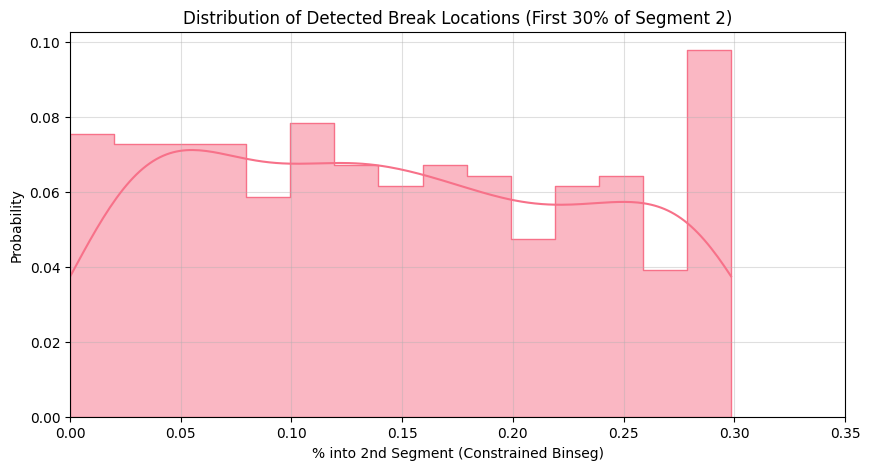

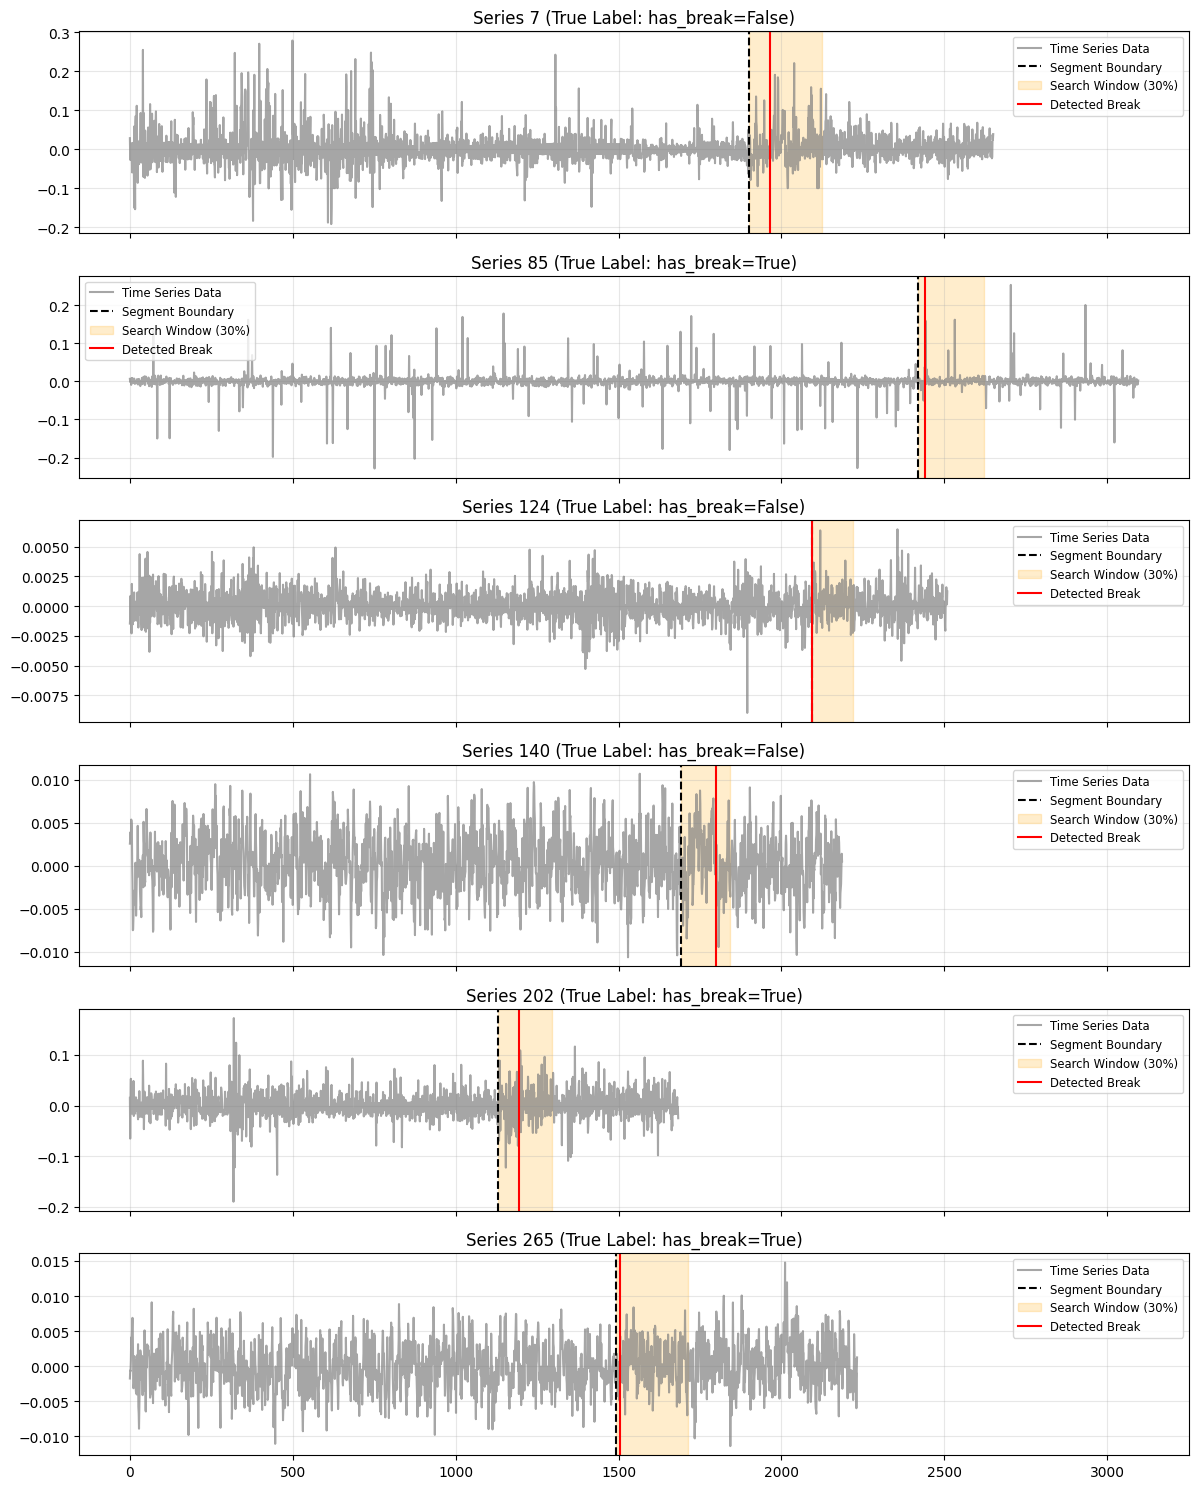

In [62]:
import ruptures as rpt
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate


# 1) Function to detect the single optimal change-point within a constrained window
def detect_constrained_break(ts_obj):
    """
    Run Binary Segmentation on the full time series to find the single best breakpoint.
    Returns the optimal breakpoint index *only if* it falls within the first 30%
    of the second segment.
    """
    series = ts_obj.values
    
    # Define the search window based on the new constraint
    k0 = len(ts_obj.period_0_values)
    p1_len = len(ts_obj.period_1_values)
    # The search window is [k0, k0 + 30% of p1_len)
    search_start = k0
    search_end = k0 + int(0.3 * p1_len)

    # Use Binseg to find the single best breakpoint across the entire series
    algo = rpt.Binseg(model="l2").fit(series)
    try:
        breakpoint_index = algo.predict(n_bkps=1)[0]
    except rpt.exceptions.NotEnoughPoints:
        return np.nan
        
    # Validate that the detected breakpoint is within the series bounds
    if breakpoint_index >= len(series):
        return np.nan
        
    # --- Apply the Constraint ---
    # Return the breakpoint only if it falls within our desired window
    if search_start <= breakpoint_index < search_end:
        return breakpoint_index
    else:
        # If the best break is outside the window, we ignore it
        return np.nan

# 2) Scan all series, detect constrained break, and compute features
feature_rows = []
labels = []
break_locations_map = {} # Store detected breaks for plotting

for sid, ts in tqdm(train_series.items()):
    full = ts.values
    # Use the new constrained detection function
    k_star = detect_constrained_break(ts)

    if pd.isna(k_star) or k_star <= 1 or k_star >= len(full) - 1:
        continue # Skip if break is not detected or is too close to the edges

    break_locations_map[sid] = k_star

    # --- Calculate Features (logic remains the same) ---
    pre_break_segment = full[:k_star]
    post_break_segment = full[k_star:]

    loc_ratio = k_star / len(full)
    mean_difference = np.abs(np.mean(post_break_segment) - np.mean(pre_break_segment))
    std_difference = np.abs(np.std(post_break_segment) - np.std(pre_break_segment))
    overall_std = np.std(full)
    scaled_mean_difference = mean_difference / overall_std if overall_std > 0 else 0

    feature_rows.append({
        'break_location_ratio': loc_ratio,
        'mean_diff': mean_difference,
        'std_diff': std_difference,
        'scaled_mean_diff': scaled_mean_difference
    })
    labels.append(ts.has_break)

feature_df = pd.DataFrame(feature_rows)
label_s = pd.Series(labels, name='has_break')

# 3) Evaluate with XGBoost using the new features
if not feature_df.empty:
    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.03,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    cv_res = cross_validate(model, feature_df, label_s, cv=5, scoring='roc_auc', n_jobs=-1)
    print("\n--- Model Evaluation (Constrained Breakpoint) ---")
    print(f"Constrained Features AUC: {cv_res['test_score'].mean().round(4)}")
else:
    print("No valid breakpoints found within the constraint window to build a model.")


# 4) Plot distribution of detected break location
if break_locations_map:
    break_info = []
    for sid, k in break_locations_map.items():
        ts = train_series[sid]
        k0 = len(ts.period_0_values)
        p1_len = len(ts.period_1_values)
        # Calculate location as a percentage into the second segment
        loc_in_p1_ratio = (k - k0) / p1_len if p1_len > 0 else 0
        break_info.append(loc_in_p1_ratio)

    plt.figure(figsize=(10, 5))
    # The x-axis now represents the % into the second segment
    sns.histplot(break_info, bins=15, stat='probability', element='step', kde=True)
    plt.xlabel('% into 2nd Segment (Constrained Binseg)')
    plt.title('Distribution of Detected Break Locations (First 30% of Segment 2)')
    plt.xlim(0, 0.35) # Focus plot on the constrained area
    plt.grid(alpha=0.4)
    plt.show()

# 5) Show some examples with the new detection method
if len(train_series) > 0:
    n = min(6, len(train_series))
    # Prioritize showing series where a break was detected
    sample_sids = list(break_locations_map.keys())
    if len(sample_sids) < n:
        all_keys = list(train_series.keys())
        np.random.shuffle(all_keys)
        additional_keys = [k for k in all_keys if k not in sample_sids]
        sample_sids.extend(additional_keys)
        
    sample_sids = sample_sids[:n]

    fig, axes = plt.subplots(n, 1, figsize=(12, 2.5 * n), sharex=True)
    if n == 1: axes = [axes]

    for ax, sid in zip(axes, sample_sids):
        ts = train_series[sid]
        k = break_locations_map.get(sid)
        k0 = len(ts.period_0_values)
        
        ax.plot(ts.values, color='grey', alpha=0.7, label='Time Series Data')
        # This line marks the boundary between the two main periods
        ax.axvline(k0, color='black', ls='--', label='Segment Boundary')
        # This shaded region shows the 30% search window
        ax.axvspan(k0, k0 + 0.3 * len(ts.period_1_values), color='orange', alpha=0.2, label='Search Window (30%)')

        if k:
            ax.axvline(k, color='red', ls='-', label='Detected Break')
            
        ax.set_title(f"Series {sid} (True Label: has_break={ts.has_break})")
        ax.legend(fontsize='small')
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


100%|██████████| 10001/10001 [00:16<00:00, 623.01it/s]



--- Model Evaluation (CUSUM Features at Constrained Breakpoint) ---
CUSUM Features AUC: 0.5794


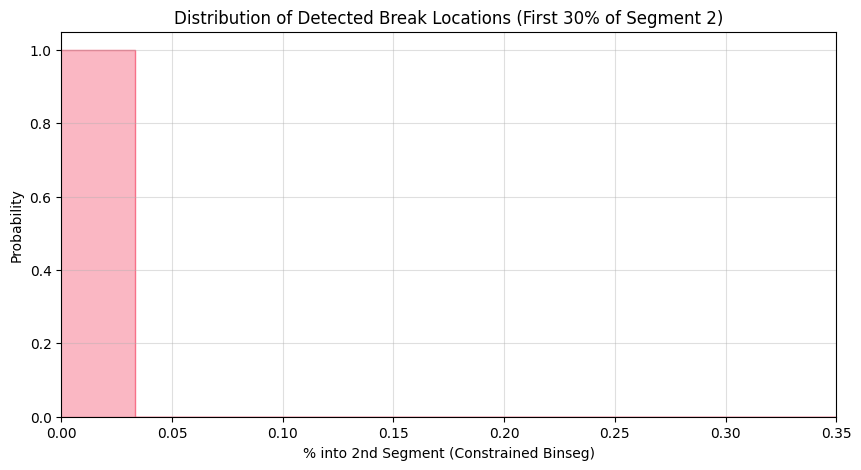

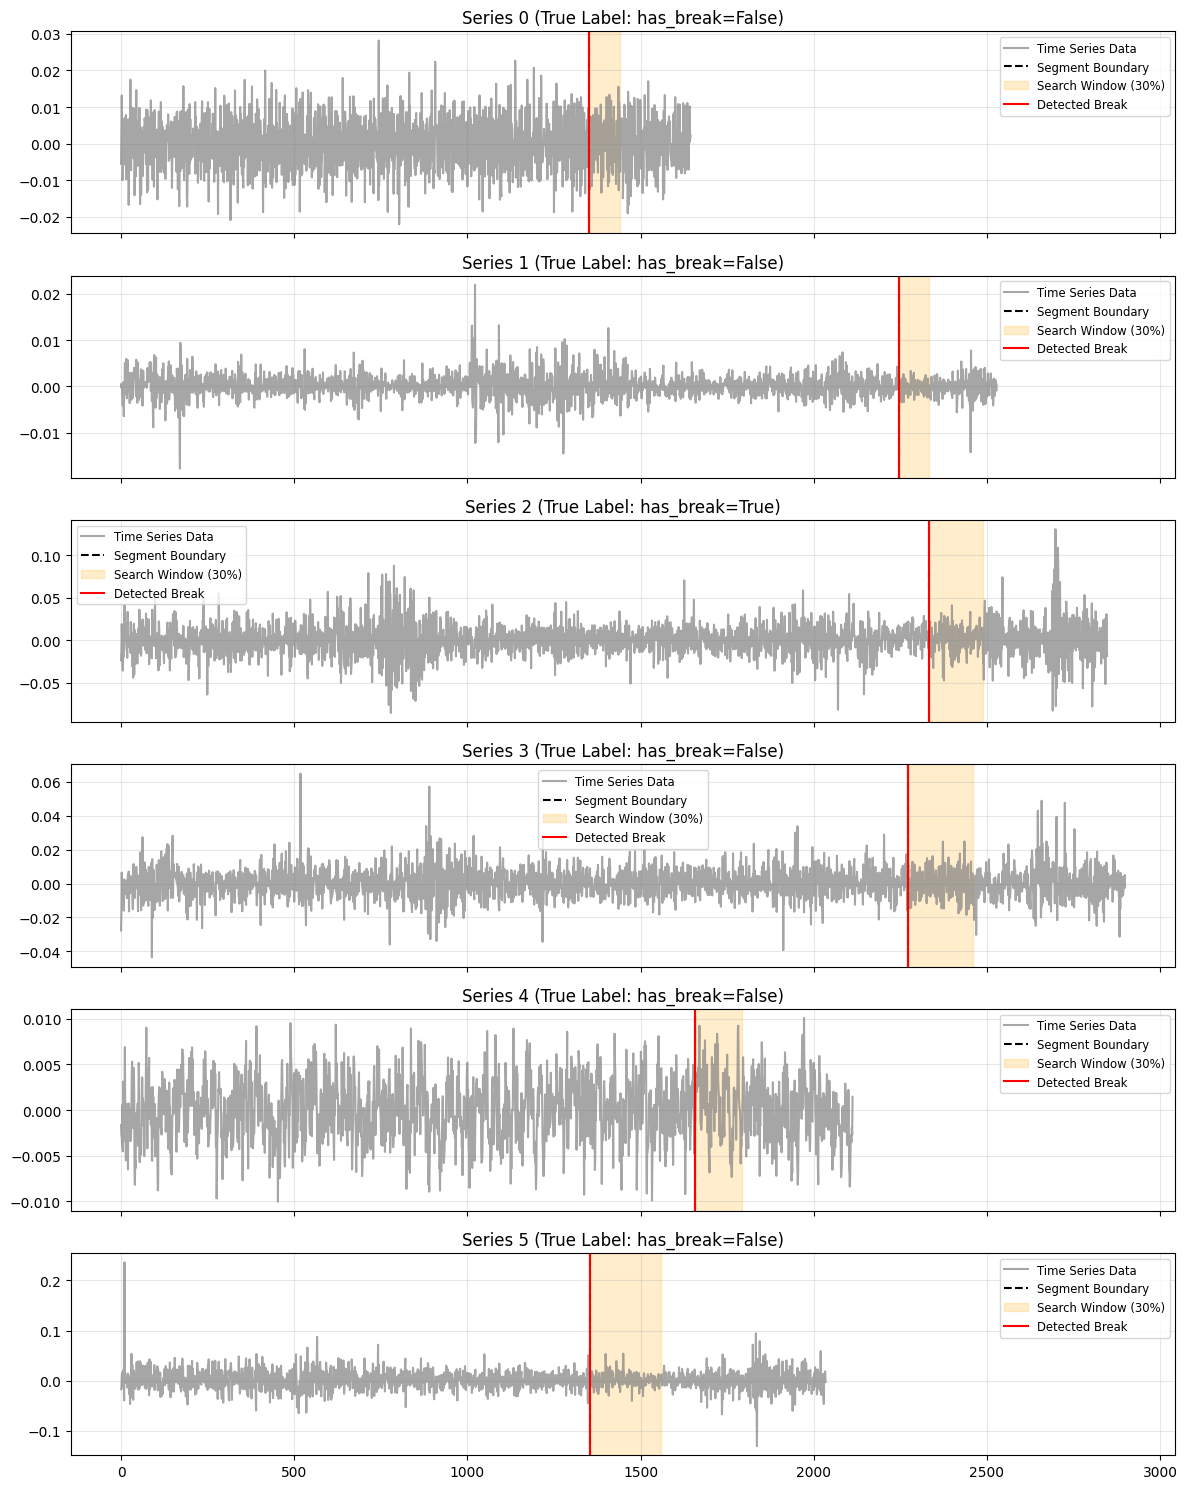

In [70]:
import ruptures as rpt
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf


# 1) Function to detect the single optimal change-point within a constrained window
def detect_constrained_break(ts_obj):
    """
    Run Binary Segmentation on the full time series to find the single best breakpoint.
    Returns the optimal breakpoint index *only if* it falls within the first 30%
    of the second segment.
    """
    series = ts_obj.values
    k0 = len(ts_obj.period_0_values)
    p1_len = len(ts_obj.period_1_values)
    search_start = k0
    search_end = k0 + int(0.3 * p1_len)
    
    algo = rpt.Binseg(model="l2").fit(series)
    try:
        breakpoint_index = algo.predict(n_bkps=1)[0]
    except rpt.exceptions.NotEnoughPoints:
        return np.nan
    
    if breakpoint_index >= len(series):
        return np.nan
        
    if search_start <= breakpoint_index < search_end:
        return breakpoint_index
    else:
        return np.nan

# 2) Helper functions for CUSUM feature calculation
def count_sig_pacf_lags(series, max_lag=15, alpha=0.05):
    """Determines the order of the AR model by finding the last significant PACF lag."""
    try:
        pacf_vals, confint = pacf(series, nlags=max_lag, alpha=alpha)
    except Exception:
        return 1  # Default to 1 if PACF fails
    
    significant_lags = 0
    for i in range(1, len(pacf_vals)):
        if not (confint[i][0] <= pacf_vals[i] <= confint[i][1]):
            significant_lags = i
        else:
            break
    return significant_lags if significant_lags > 0 else 1

def compute_cusum_at_k(series, lag, k):
    """
    Computes CUSUM and CUSUM-of-Squares statistics at a specific point k,
    based on the residuals of a full-sample AR(lag) model.
    """
    n = len(series)
    if lag >= n or k >= n or k <= lag:
        return np.nan, np.nan, np.nan, np.nan

    # Create lagged variables for the AR(lag) model
    X = sm.tsa.lagmat(series, maxlag=lag, trim='both', original='ex')
    X = sm.add_constant(X, prepend=True)
    y = series[lag:]
    
    if X.shape[0] < X.shape[1]:
        return np.nan, np.nan, np.nan, np.nan

    try:
        model = sm.OLS(y, X).fit()
        e = model.resid
        sigma_e = np.std(e, ddof=model.df_model)
        
        if sigma_e < 1e-9: return (np.nan,) * 4
        
        # CUSUM statistic (based on standardized residuals)
        w = e / sigma_e
        W_t = np.cumsum(w)
        
        # CUSUM of squares statistic
        S_t = np.cumsum(e**2) / np.sum(e**2)
        
        # Map the breakpoint 'k' to the residuals' index
        resid_index = k - lag
        
        if not (0 <= resid_index < len(W_t)):
            return (np.nan,) * 4
            
        T = W_t[resid_index]
        Z = S_t[resid_index]
        
        # P-values for single points in the path are not standard and are returned as NaN.
        pT = np.nan
        pZ = np.nan
        
        return T, pT, Z, pZ
        
    except (np.linalg.LinAlgError, ValueError):
        return np.nan, np.nan, np.nan, np.nan

# 3) Scan all series, detect break, and compute CUSUM features
feature_rows = []
labels = []
break_locations_map = {}

for sid, ts in tqdm(train_series.items()):
    full = ts.values
    # k_star = detect_constrained_break(ts)
    # 
    # if pd.isna(k_star) or k_star <= 1 or k_star >= len(full) - 1:
    #     continue
    # 
    # break_locations_map[sid] = k_star
    break_locations_map[sid] = len(ts.period_0_values)
    k_star = len(ts.period_0_values)
    
    # Calculate features at the identified breakpoint
    lag = count_sig_pacf_lags(full)
    T, pT, Z, pZ = compute_cusum_at_k(full, lag, int(k_star))
    
    if np.isnan(T):
        continue

    feature_rows.append({
        'T_cumsum': T,
        'p_cumsum': pT,
        'cusumsq_stat': Z,
        'cusumsq_pvalue': pZ
    })
    labels.append(ts.has_break)

# Create final DataFrame, dropping rows where features could not be computed
feature_df = pd.DataFrame(feature_rows).dropna(subset=['T_cumsum', 'cusumsq_stat'])
label_s = pd.Series(labels, name='has_break', index=feature_df.index)


# 4) Evaluate with XGBoost using the CUSUM features
if not feature_df.empty:
    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.03,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
    cv_res = cross_validate(model, feature_df.drop(columns=['p_cumsum', 'cusumsq_pvalue']), label_s, cv=5, scoring='roc_auc', n_jobs=-1)
    print("\n--- Model Evaluation (CUSUM Features at Constrained Breakpoint) ---")
    print(f"CUSUM Features AUC: {cv_res['test_score'].mean().round(4)}")
else:
    print("No valid breakpoints found to build a model.")


# 5) Plot distribution of detected break location
if break_locations_map:
    break_info = []
    for sid, k in break_locations_map.items():
        ts = train_series[sid]
        k0 = len(ts.period_0_values)
        p1_len = len(ts.period_1_values)
        if p1_len > 0:
            break_info.append((k - k0) / p1_len)

    plt.figure(figsize=(10, 5))
    sns.histplot(break_info, bins=15, stat='probability', element='step', kde=True)
    plt.xlabel('% into 2nd Segment (Constrained Binseg)')
    plt.title('Distribution of Detected Break Locations (First 30% of Segment 2)')
    plt.xlim(0, 0.35)
    plt.grid(alpha=0.4)
    plt.show()

# 6) Show some examples
if len(train_series) > 0:
    n = min(6, len(train_series))
    sample_sids = list(break_locations_map.keys())
    if len(sample_sids) < n:
        all_keys = list(train_series.keys())
        np.random.shuffle(all_keys)
        additional_keys = [k for k in all_keys if k not in sample_sids]
        sample_sids.extend(additional_keys)
    sample_sids = sample_sids[:n]

    fig, axes = plt.subplots(n, 1, figsize=(12, 2.5 * n), sharex=True)
    if n == 1: axes = [axes]

    for ax, sid in zip(axes, sample_sids):
        ts = train_series[sid]
        k = break_locations_map.get(sid)
        k0 = len(ts.period_0_values)
        
        ax.plot(ts.values, color='grey', alpha=0.7, label='Time Series Data')
        ax.axvline(k0, color='black', ls='--', label='Segment Boundary')
        ax.axvspan(k0, k0 + 0.3 * len(ts.period_1_values), color='orange', alpha=0.2, label='Search Window (30%)')

        if k:
            ax.axvline(k, color='red', ls='-', label='Detected Break')
            
        ax.set_title(f"Series {sid} (True Label: has_break={ts.has_break})")
        ax.legend(fontsize='small')
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()